In [1]:
import pandas as pd
import numpy as np

In [2]:
#!source venv/bin/activate

In [3]:
!pip3 install sklearn matplotlib nltk seaborn xgboost

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [4]:
pwd

'/Users/mallepudisriharsha/Proton/Code/Data Science/Email Spam Classifier'

In [5]:
df = pd.read_csv('data/spam.csv', encoding='latin-1')

In [6]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
1731,ham,Lol. Well quality aint bad at all so i aint co...,NaN,NaN,NaN
2632,ham,I WILL CAL YOU SIR. In meeting,NaN,NaN,NaN
142,ham,A swt thought: \Nver get tired of doing little...,NaN,NaN,NaN
3351,ham,Call him and say you not coming today ok and t...,NaN,NaN,NaN
2654,ham,Its sarcasm.. .nt scarcasim,NaN,NaN,NaN


In [7]:
df.shape

(5572, 5)

So far, SMS/Email Data has been loaded into the dataframe. Now, the process will be divided into 6 steps:

1. Data Cleaning
2. Exploratory Data Analysis
3. Text Preprocessing
4. Modelling
5. Evaluation
6. Deployment on Heroku

# Step 1: Data Cleaning

If we look at the sample data from df.sample() statement above, we see that the values in the columns Unnamed 2, 3 and 4 are almost NaN. So, let's take a look at their non-null value count

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB



Like we suspected, there are not much useful data in these three columns, so we'll drop them


In [9]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [10]:
df.sample(5)

,v1,v2
2410,ham,Ok... Thanx... Gd nite 2 Ì_ too...
5340,ham,Are u awake? Is there snow there?
922,ham,It shall be fine. I have avalarr now. Will hol...
3872,ham,"Happy or sad , one thing about past is- \Its n..."
4439,ham,I've got it down to a tea. not sure which flavour


It's a lot cleaner now that the unnecessary columns are removed. Let's also rename the columns so that they are more meaningful

In [11]:
df.rename(columns={ 'v1':'spam/ham', 'v2':'message'}, inplace=True)

In [12]:
df.head()

,spam/ham,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's convert the spam/ham to numbers so that it's more understandable for the algorithms. I'm going to create an object of the class LabelEncoder from Scikit Learn module to convert the spam/ham into numbers

In [13]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [14]:
df['spam/ham'] = encoder.fit_transform(df['spam/ham'])

In [15]:
df.head()

,spam/ham,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Checking for __null values__ in the dataframe

In [16]:
df.isnull().sum()

spam/ham    0
message     0
dtype: int64

Seems like there are no null values in these columns. Let's check for duplicate values

In [17]:
df.duplicated().sum()

403

In [18]:
df.drop_duplicates(keep='first', inplace=True)

In [19]:
df.duplicated().sum()

0

In [20]:
df.shape

(5169, 2)

Around 400+ duplicates have been removed from our data. Let's take a deeper look at the data

# Step 2: Exploratory Data Analysis

I'm going to check the distribution between ham and spam in my data.

In [21]:
df['spam/ham'].value_counts()

0    4516
1     653
Name: spam/ham, dtype: int64

Isn't it better if we plot it on a pie chart for more visual appeal? Let's do it then

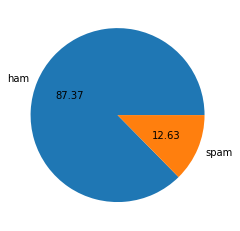

In [22]:
import matplotlib.pyplot as plt
plt.pie(df['spam/ham'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')
plt.show()

In the above code snippet, autopct is to show the percentage values in decimal format allowing precision upto 2 digits after decimal. 

Looking at the chart, we can see that the data is imbalanced, which is to be noted

We may need to process the message text to identify the no. of characters, words and sentences there are, in a message. This may provide us an insight whether there's any relation between these counts and them being spam/ham

In [23]:
import nltk
nltk.download('punkt')   

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mallepudisriharsha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
df['num_char'] = df['message'].apply(len)

In [25]:
df['num_words'] = df['message'].apply(lambda x:len(nltk.word_tokenize(x)))

In [26]:
df['num_sent'] = df['message'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [27]:
df

,spam/ham,message,num_char,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2
5570,0,The guy did some bitching but I acted like i'd...,125,27,1


If we try to describe the new columns we created to see how these values differ on an average between spam and ham, this is how it looks like.

For ham:

In [28]:
df[df['spam/ham'] == 0][['num_char', 'num_words', 'num_sent']].describe()

,num_char,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.120903,1.799601
std,56.358207,13.493725,1.278465
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


For Spam:

In [29]:
df[df['spam/ham'] == 1][['num_char', 'num_words', 'num_sent']].describe()

,num_char,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


If we closely look at the average character/word/sentence count, spam messages have a higher value than that of a ham message. Let's try to plot the same on a histogram to see the value ranges and distribution

<AxesSubplot:xlabel='num_char', ylabel='Count'>

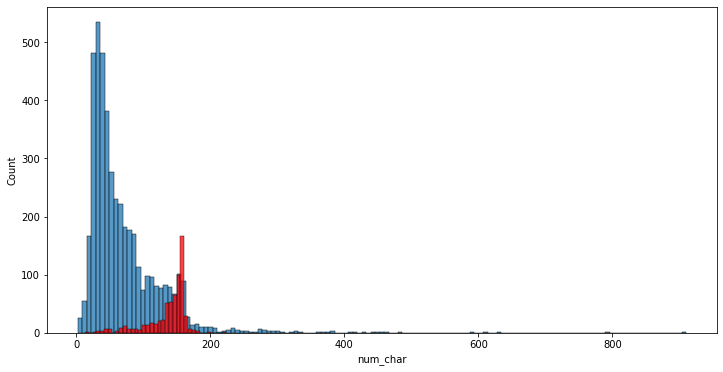

In [30]:
import seaborn as sb

plt.figure(figsize=(12,6))
sb.histplot(df[df['spam/ham'] == 0]['num_char']) #ham
sb.histplot(df[df['spam/ham'] == 1]['num_char'], color='red') #spam

<AxesSubplot:xlabel='num_words', ylabel='Count'>

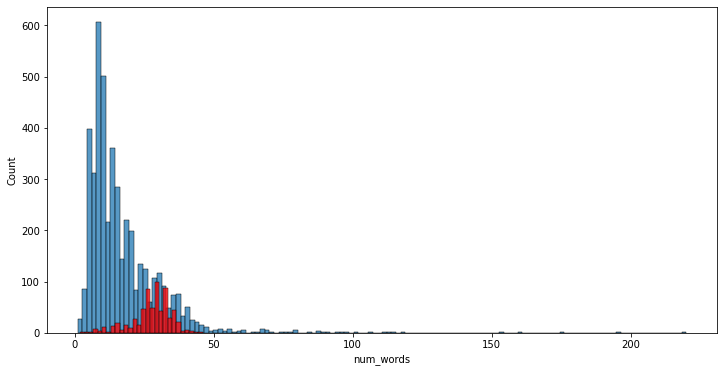

In [31]:
plt.figure(figsize=(12,6))
sb.histplot(df[df['spam/ham'] == 0]['num_words']) #ham
sb.histplot(df[df['spam/ham'] == 1]['num_words'], color='red') #spam

<AxesSubplot:xlabel='num_sent', ylabel='Count'>

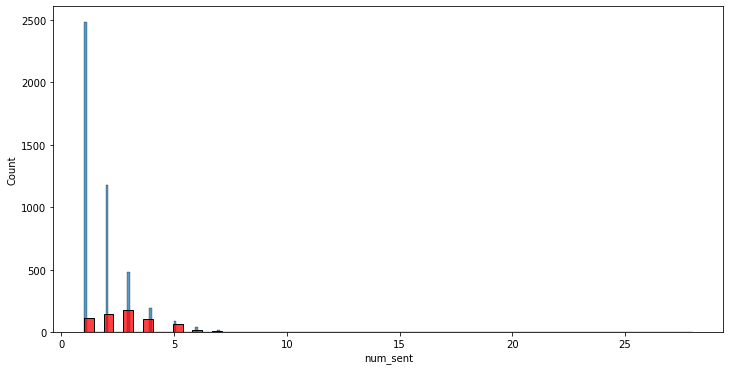

In [32]:
plt.figure(figsize=(12,6))
sb.histplot(df[df['spam/ham'] == 0]['num_sent']) #ham
sb.histplot(df[df['spam/ham'] == 1]['num_sent'], color='red') #spam

Let's see if there's any evident relationship between the columns

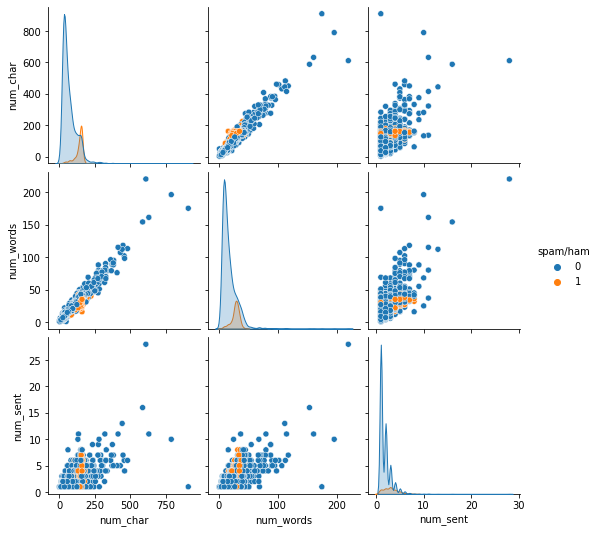

In [33]:
sb.pairplot(df,hue='spam/ham')

This gives us an idea that the columns num_words and num_char are highly correlated and that multi collinearity exists. However, to get the correlation in numbers, let's check Pearson Correlation Coefficient

In [34]:
df.corr()

,spam/ham,num_char,num_words,num_sent
spam/ham,1.000000,0.384717,0.262984,0.284901
num_char,0.384717,1.000000,0.965770,0.638143
num_words,0.262984,0.965770,1.000000,0.684541
num_sent,0.284901,0.638143,0.684541,1.000000


If we check the same in a heatmap for a visual aid:

<AxesSubplot:>

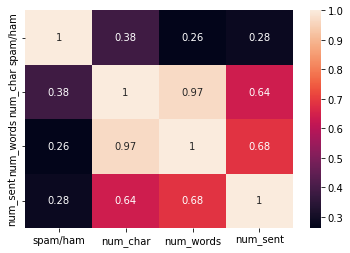

In [35]:
sb.heatmap(df.corr(),annot=True)

So, this makes it evident that the columns are highly correlated and so, we need to use only one of them. Let's pick num_char as our winner and proceed with the preprocessing

# Step 3: Text Preprocessing

Now, what does this include? Since the data is text, we'll first make them all uniform w.r.t. case, that is, lower case. Convert them to tokens. Then, we'll remove stopwords from English language, and special characters if any. Then, to reduce redundancy, we'll perform Lemmatization which groups similar words into one. So, the process looks like this:

1. Convert the message to lowercase
2. Tokenization
3. Removing special chars
4. Removing stop words
5. Lemmatization

In [36]:
# nltk.download('stopwords')
# nltk.download('all')

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# assigning keys to parts of speech
tags_dict = {
                'J': wordnet.ADJ,
                'N': wordnet.NOUN,
                'V': wordnet.VERB,
                'R': wordnet.ADV
            } 

def message_transformer(text):
    
    # converting to lowercase
    text = text.lower()
    
    # converting words to tokens
    text = nltk.word_tokenize(text)
    
    y = []
    
    # checking for alpha numeric and eliminating special chars
    for i in text:
        if i.isalnum():
            y.append(i)
    

    text = y[:]
    y.clear()
    
    # removing english stopwords
    for i in text:
        if i not in stopwords.words('english'):
            y.append(i)
    
    # lemmatising the words
    text = y[:]
    y.clear()
    lem = WordNetLemmatizer()
    for i in text:
        tag = pos_tag([i])[0][1][0]
        if tag in tags_dict.keys():
            y.append(lem.lemmatize(i, tags_dict[tag]))
        else:
            y.append(lem.lemmatize(i, wordnet.NOUN))
            
    return " ".join(sorted(set(y), key=y.index))

In [37]:
# testing pos_tag method
pos_tag(['angrily'])[0][1][0]

'R'

In [38]:
# testing our fucntion
message_transformer("Hi babu, how are you, Nveen? I'm going to go dance and dancing")

'hi babu nveen go dance'

In [39]:
df['final_text'] = df['message'].apply(message_transformer)

In [40]:
df.head()

,spam/ham,message,num_char,num_words,num_sent,final_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say early hor c already
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think go usf life around though


Let's create a wordcloud for each of the categories, Spam and Ham to see which words are most used

In [41]:
!pip3 install wordcloud
from wordcloud import WordCloud

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [116]:
wc = WordCloud(width=800, height=800, min_font_size=12, background_color='white')

spam_cloud = wc.generate(df[df['spam/ham']==1]['final_text'].str.cat(sep=" "))

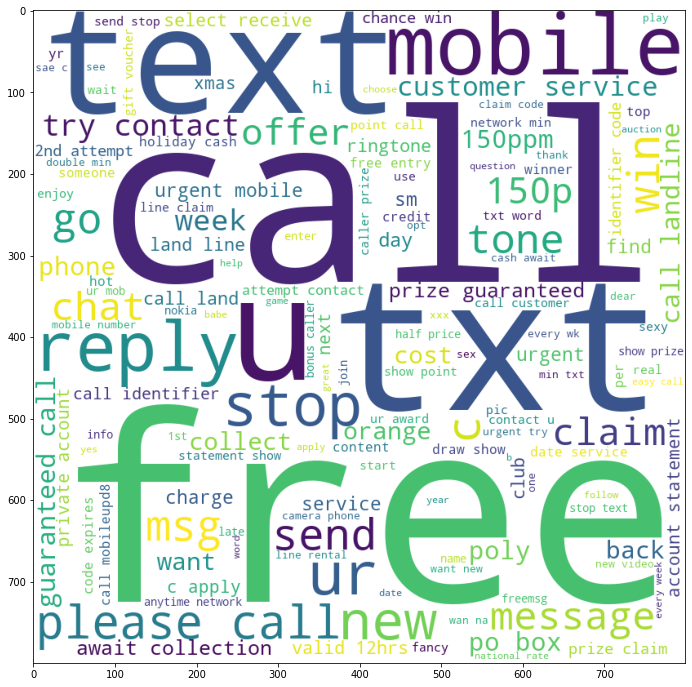

In [117]:
plt.figure(figsize=(12,12))
plt.imshow(spam_cloud)

In [118]:
wc = WordCloud(width=800, height=800, min_font_size=12, background_color='white')

ham_cloud = wc.generate(df[df['spam/ham']==0]['final_text'].str.cat(sep=" "))

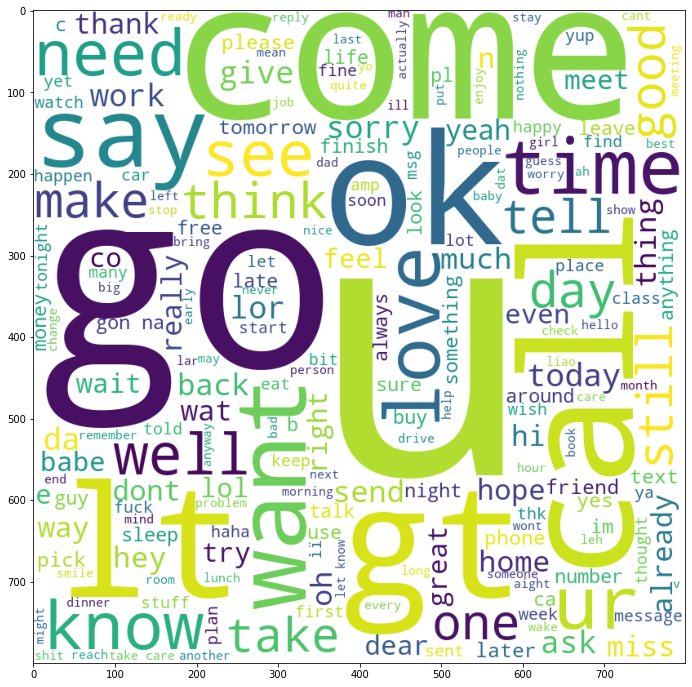

In [119]:
plt.figure(figsize=(12,12))
plt.imshow(ham_cloud)

Here we can see what words are used most frequently in each category. But I want to the counts of top 25 words from each category. Let's do it

In [45]:
spam_words = []
spam_text = df[df['spam/ham'] == 1]['final_text'].tolist()
for msg in spam_text:
    for word in msg.split():
        spam_words.append(word)

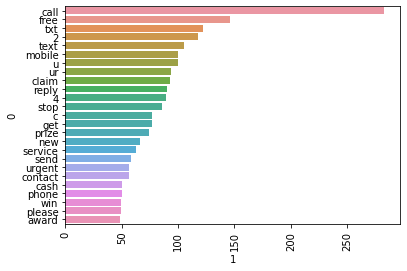

In [46]:
from collections import Counter
sb.barplot(x=pd.DataFrame(Counter(spam_words).most_common(25))[1], y=pd.DataFrame(Counter(spam_words).most_common(25))[0])
plt.xticks(rotation='vertical')
plt.show()

In [47]:
ham_words = []
ham_text = df[df['spam/ham'] == 0]['final_text'].tolist()
for msg in ham_text:
    for word in msg.split():
        ham_words.append(word)

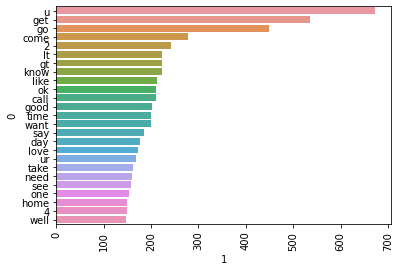

In [48]:
sb.barplot(x=pd.DataFrame(Counter(ham_words).most_common(25))[1], y=pd.DataFrame(Counter(ham_words).most_common(25))[0])
plt.xticks(rotation='vertical')
plt.show()

# Step 4: Model Building

## CountVectoriser
Since machines don't understand text like they understand number, we need to convert the text to vectors. To do that, let's use CountVectorizer class from Sklearn

In [77]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [78]:
X = cv.fit_transform(df['final_text']).toarray()
y = df['spam/ham'].values

We are now going to split the X and y into two data sets, X_train, y_train and X_test, y_test and then use Naive Bayes as it performs well in cases of categorical input variables compared to numerical variables

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [81]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [83]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(precision_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))

0.8655705996131529
0.5122950819672131
[[770 119]
 [ 20 125]]


In [55]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(precision_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))

0.9738878143133463
0.8933333333333333
[[873  16]
 [ 11 134]]


In [84]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(precision_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))

0.9642166344294004
0.9655172413793104
[[885   4]
 [ 33 112]]


Since our data is imbalanced, we should be looking more at Precision score, rather than accuracy to ensure low false positives. We wouldn't want our important mails to end up in spam, would we?

Well, if you look at the precision scores of the above algorithms, Bernouli's Naive Bayes did better with 96.55% of precision. Do you think we can score higher with a different vectorizer? Let's see

## TFIDF Vectorizer

In [85]:
X = tfidf.fit_transform(df['final_text']).toarray()
y = df['spam/ham'].values

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [87]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(precision_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))

0.8578336557059961
0.49586776859504134
[[767 122]
 [ 25 120]]


In [88]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(precision_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))

0.971953578336557
0.9915254237288136
[[888   1]
 [ 28 117]]


In [61]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(precision_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))

0.9642166344294004
0.9655172413793104
[[885   4]
 [ 33 112]]


Multinomial Naive bayes performed a lot lot better than the other two incase of TFIDF. So, we'll choose this as our winner amoing the above. However, let's give Ensemble Learning a try to see how other classifiers are performing on this data. For that, let's choose

1. Logistic Regression Classifier
2. Support Vector Classifier
3. Decision Trees
4. KNeighbors Classifier
5. Random Forest
6. Adaboost
7. Bagging Classifier
8. Extra Trees Classifier
9. Gradient boost
10. XGBoost

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [90]:
lrc = LogisticRegression(solver='liblinear', penalty='l1')
svc = SVC(kernel='sigmoid', gamma=1.0)
dct = DecisionTreeClassifier(max_depth=5)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
abc = AdaBoostClassifier(n_estimators=50, random_state=42)
bc = BaggingClassifier(n_estimators=50, random_state=42)
etc = ExtraTreesClassifier(n_estimators=50, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=50, random_state=42)
xbc = XGBClassifier(n_estimators=50, use_label_encoder=False, random_state=42)

In [91]:
classifiers = {
                'LRC': lrc,
                'SVC': svc,
                'DCT': dct,
                'KNC': knc,
                'MNB': mnb,
                'RFC': rfc,
                'ABC': abc,
                'BC': bc,
                'ETC': etc,
                'GBC': gbc,
                'XBC': xbc
}

Now, let's build a function to run these classifiers in a loop to generate our metrics - Accuracy and Precision

In [92]:
accuracies = []
precisions = []
names = []

def train_clf(classifiers,X_train,X_test,y_train,y_test):
    
    for clf in classifiers.values():
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)

        clf_accuracy = accuracy_score(y_test,y_pred)
        clf_precision = precision_score(y_test,y_pred)
        
        names.append(clf)
        accuracies.append(clf_accuracy)
        precisions.append(clf_precision)
        
    return names, accuracies, precisions

In [93]:
train_clf(classifiers,X_train,X_test,y_train,y_test)

[13:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


([LogisticRegression(penalty='l1', solver='liblinear'),
  SVC(gamma=1.0, kernel='sigmoid'),
  DecisionTreeClassifier(max_depth=5),
  KNeighborsClassifier(),
  MultinomialNB(),
  RandomForestClassifier(n_estimators=50, random_state=42),
  AdaBoostClassifier(random_state=42),
  BaggingClassifier(n_estimators=50, random_state=42),
  ExtraTreesClassifier(n_estimators=50, random_state=42),
  GradientBoostingClassifier(n_estimators=50, random_state=42),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                gamma=0, gpu_id=-1, importance_type=None,
                interaction_constraints='', learning_rate=0.300000012,
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=50, n_jobs=4,
                num_parallel_tree=1, predictor='auto', random_state=42,
                reg_alpha=0, reg_lambda=1, s

In [94]:
score_df = pd.DataFrame({'Algorithm':classifiers.keys(), 'Accuracy':accuracies, 'Precision':precisions})

In [68]:
#score_df_copy = score_df.copy(deep=True)

In [95]:
score_df_copy

,Algorithm,Accuracy,Precision
0,LRC,0.947776,0.882353
1,SVC,0.972921,0.968000
2,DCT,0.941973,0.840000
3,KNC,0.892650,1.000000
4,MNB,0.959381,0.990476
5,RFC,0.970986,1.000000
6,ABC,0.957447,0.904000
7,BC,0.965184,0.903704
8,ETC,0.970986,0.975207
9,GBC,0.949710,0.942857


Now, If I try with max_features = 3000 for TFIDF to see if scores improve, below is the data:

In [96]:
score_df = score_df.rename(columns={'Accuracy':'Accuracy_3000', 'Precision':'Precision_3000'})

In [97]:
score_df

,Algorithm,Accuracy_3000,Precision_3000
0,LRC,0.950677,0.891667
1,SVC,0.976789,0.954887
2,DCT,0.935203,0.814516
3,KNC,0.905222,1.000000
4,MNB,0.971954,0.991525
5,RFC,0.970986,0.991453
6,ABC,0.953578,0.864662
7,BC,0.970019,0.925373
8,ETC,0.971954,0.975410
9,GBC,0.948743,0.942308


In [98]:
score_df = score_df_copy.merge(score_df, on='Algorithm')

In [99]:
score_df.sort_values('Precision_3000', ascending=False)

,Algorithm,Accuracy,Precision,Accuracy_3000,Precision_3000
3,KNC,0.892650,1.000000,0.905222,1.000000
4,MNB,0.959381,0.990476,0.971954,0.991525
5,RFC,0.970986,1.000000,0.970986,0.991453
8,ETC,0.970986,0.975207,0.971954,0.975410
1,SVC,0.972921,0.968000,0.976789,0.954887
10,XBC,0.974855,0.968504,0.970019,0.945312
9,GBC,0.949710,0.942857,0.948743,0.942308
7,BC,0.965184,0.903704,0.970019,0.925373
0,LRC,0.947776,0.882353,0.950677,0.891667
6,ABC,0.957447,0.904000,0.953578,0.864662


We see that KNeighbors Classifier gives highest precision 1.0 but it's accuracy has taken a huge hit, so the next best algorithms are:

1. Multinomail Naive Bayes
2. Random Forest
3. Extra Trees Classifer
4. Support Vector Classifier

I'll now reshape the dataframe using melt to be able to use categorical plot on the data

In [100]:
score_df = pd.melt(score_df, id_vars=['Algorithm'], value_vars=['Accuracy_3000', 'Precision_3000'])
score_df

,Algorithm,variable,value
0,LRC,Accuracy_3000,0.950677
1,SVC,Accuracy_3000,0.976789
2,DCT,Accuracy_3000,0.935203
3,KNC,Accuracy_3000,0.905222
4,MNB,Accuracy_3000,0.971954
5,RFC,Accuracy_3000,0.970986
6,ABC,Accuracy_3000,0.953578
7,BC,Accuracy_3000,0.970019
8,ETC,Accuracy_3000,0.971954
9,GBC,Accuracy_3000,0.948743


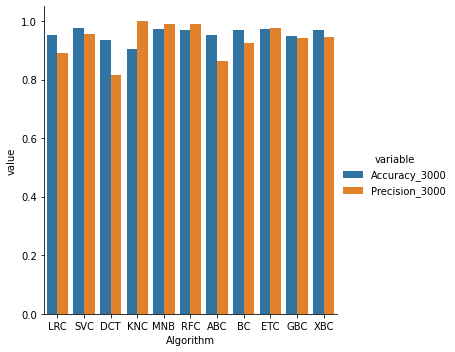

In [101]:
sb.catplot(x='Algorithm', y='value', hue='variable', data=score_df, kind='bar')
plt.show()

Since MNB performed better in all aspects, we'll use MNB as our model. We can also try performing Voting Classifier and Stacking to see if the algorithm improves. But for now, let's proceed with this. I'm going to dump our vectorizer and model into pickle files to use them in our website

In [102]:
import pickle
pickle.dump(tfidf, open('vectorize.pkl','wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))
pickle.dump(message_transformer, open('transform.pkl', 'wb'))